# **INF.581 PROJECT NOTEBOOK**
# *AVOIDING FOOD WASTE : DYNAMIC PRICES IN RESTAURANTS* 

*Anonymous Authors*

___

## **INTRODUCTION**

Through this notebook,  we want to design algorithms able to dinamically find optimized prices for retaurant menus. The  aim  of  our  project  is to  provide  prices  that would enable  restaurants  to  avoid  food  waste at the  end  of  the  night. Here are two articles about the necessity of reducing fod waste:
- [Americans Waste About A Pound Of Food A Day, USDA Study Finds](https://www.forbes.com/sites/christinatroitino/2018/04/23/americans-waste-about-a-pound-of-food-a-day-usda-study-finds/?sh=4e84a9d44ec3);
- [A third of all food in the U.S. gets wasted. Fixing that could help fight climate change](https://www.washingtonpost.com/climate-solutions/2021/02/25/climate-curious-food-waste/))

The  principle  is  pretty  easy. Let's take an exampel to illustrate it: if a Pizzeria has tomatoes for 20 more pizzas and it is already 10 p.m., those pizzas will not be consumed which will lead to food waste because those tomatoes cannot be used the day after. Our algorithm has to find prices that would attract clients who will consume those 20 extra Pizzas. Let's precise that here we assume that selling meals at lower prices is better than wasting food.

We  are  convinced  that  the  data  collected  by  online  food platforms  such  as  Uber  Eats  is  enough  to  build  efficient algorithm  to  avoid  food  waste.  However  we  do  not  have any access  to it and  one  of  the  major challenges   we   face   is   building   a   realistic   simulation   ofclients consumption. Indeed, we have to produce randomizedrealistic  clients’  behaviors  for  each  day  of  our  simulation.We  also  have  to  build  a  sort  of  city,  chose  the  number  ofrestaurants, the prices of their plates, the size of their stocks ...

## **I. INITIALIZATION**

### *I.A. LIBRARIES IMPORT*

In [ ]:
import gym
from gym import spaces
from gym.spaces import Discrete
from gym.spaces import Tuple

import matplotlib.pyplot as plt
import numpy as np

### *I.B. GLOBAL VARIABLES*

Here is a description of the variables declared:

- **NR** [integer]:<br>
The total number of restaurants.

- **RATINGS** [float array]:<br>
An array storing the ratings of the NR restaurants. Initially each reastaurant is given a rating which is a float value between 0 and 1 randomly attributed according to a normal law with a $3.77$ mean and a $0.3$ variance with a normalizing factor of $\frac{1}{5}$ (since the maximum rating is 5). Those parameters have been determined accordingly to the following *medium* study: [Restaurant Ratings On Yelp Are Remarkably Consistent, No Matter Who’s Writing Them, When, And Where](https://medium.com/locally-optimal/restaurant-ratings-on-yelp-are-remarkably-consistent-no-matter-whos-writing-them-when-and-where-10c54727454)

- **T** (integer):<br>
The total period of time (in arbitrary units) the restaurants have to sell their meals.

- **NC**:<br>
The total number of potentiall clients over the period of time. Depending on the total stock of the restaurant, either some of them may not be able to order a meal or the restaurant may not have enough clients.

- **P$_{MIN}$**,**P$_{MAX}$**:<br>
The minimum and the maximum price of the meals.

- **NP**:<br>
The number of possible prices between P$_{MIN}$ and P$_{MAX}$ which set is defined as it follows: $A=\{ P_{MIN} + i\times\frac{(P_{MAX}-P_{MIN})}{N_P} |i\in[\![0,N_P]\!]\}$

- **C$_{MAX}$**:<br>
The minimum and the maximum number of the meals per restaurant.

- **POLICIES**:<br>
The policies to consider when taking an action (defining a price).

In [ ]:
# number of restaurants
NR = 3

# restaurants ratings
RATINGS = np.sort(np.round(np.random.normal(3.77, 0.3, NR) / 5, 2))

# period of time
T = 500

# minimum and maximum prices for meals (arbitrary units)
P_MIN,P_MAX = 1,10

# number of subdivision between P_MIN and P_MAX for the prices
NP = 9

# set of prices
A = np.array([P_MIN + i*(P_MAX - P_MIN)/NP for i in range(NP+1)])

# minimum and maximum stocks (arbitrary units)
C_MAX = 300

# number of potential clients (demand slightly higher than offer)
NC = int(1.2 * NR * C_MAX)

POLICIES = ["average", "dynamic", "max", "min", "random"]

The following functions can be used later in order to modify or get information about those variables:

In [ ]:
def set_variables(nr=3, t=500, p_min=1, p_max=10, n_p=9, c_max=300):

  global NR, RATINGS, T, NC, P_MIN, P_MAX, NP, A, C_MAX

  NC = int(1.2 * nr * c_max)

  NR, T, P_MIN, P_MAX, NP, C_MAX = nr, t, p_min, p_max, n_p, c_max

  RATINGS = np.sort(np.round(np.random.normal(3.77, 0.3, nr) / 5, 2))

  A = np.array([P_MIN + i * (P_MAX - P_MIN) / n_p for i in range(n_p +1)])

In [ ]:
def get_variables():

  print("NUMBER OF RESTAURANTS:\t {} restaurants".format(NR))
  print("RESTAURANTS RATINGS:\t {}".format(list(RATINGS)))
  print("TOTAL PERIOD OF TIME:\t {} periods".format(T))
  print("TOTAL NUMBER OF CLIENTS: {} clients".format(NC))
  print("TOTAL SET OF PRICES:\t {}".format(list(A)))
  print("MAX NUMBER OF MEALS:\t {} meals per restaurant".format(C_MAX))

In [ ]:
set_variables()
get_variables()

NUMBER OF RESTAURANTS:	 3 restaurants
RESTAURANTS RATINGS:	 [0.76, 0.77, 0.8]
TOTAL PERIOD OF TIME:	 500 periods
TOTAL NUMBER OF CLIENTS: 1080 clients
TOTAL SET OF PRICES:	 [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
MAX NUMBER OF MEALS:	 300 meals per restaurant


### *I.C. CLIENTS DISTRIBUTION*

The number of clients (**current_NC**) wanting to order meals on the platform at some time t, is determined according a normal law with a $\frac{2}{3}$ mean and a $0.2$ variance. In order to find those parameters we used the following piece of information:
- https://help.uber.com/en/driving-and-delivering/article/when-and-where-will-i-get-the-most-delivery-requests?nodeId=3ece579a-21d3-4b0c-96fd-f3f240308ecb.

According to Uber Eats, the orders peak is 1h30 before the closing time of the restaurant which represent around $\frac{2}{3}$ of the opening time of the restaurants.

*Remark: to make this model even more interesting, we could hace considered the day of the week and the exact period of the day to modify both T and NC before finally computing the time distribution.*

In [ ]:
# gives the distribution of clients over the time
def get_time_distribution(TIME,NC):

  mu, sigma, distribution = (2/3) * T, 0.2 * T, np.zeros([T])

  # normal distribution
  for t in range(T):
    d = ((2*np.pi*(sigma**2))**(-1/2)) * np.exp((-1/2)*(t-mu)**2/(sigma**2))
    distribution[t] = d  
  
  # normalization of the distribution
  distribution = distribution / np.sum(distribution)

  # useful to draw some period of time from which we remove or add clients
  # (the less likely the period is to have many clients
  # the more it is to have clients removed)
  distribution_proba = np.copy(distribution)
  distribution_proba_inv = (1 - np.copy(distribution)) / (T - 1)

  # the following lines are needed to consider suitable integer values
  distribution = np.round(1/2 + NC * distribution)

  # the following final lines are needed to conserve the total number of clients
  # (modified due to rounding)

  distribution_NC = np.sum(distribution)

  # more clients than needed
  if distribution_NC > NC:
    # we randomly remove clients at some period of time
    while distribution_NC > NC:
      t = np.random.choice(T, p = distribution_proba_inv)
      if distribution[t] > 0:
        distribution[t] -= 1
        distribution_NC -= 1
  
  # less clients than needed
  elif distribution_NC < NC:
    # we randomly add clients at some period of time
    while distribution_NC < NC:
      t = np.random.choice(T, p = distribution_proba)
      distribution[t] += 1
      distribution_NC += 1

  return distribution

In [ ]:
def plot_time_distribution(time_distribution):

  T = len(time_distribution)
  
  # time
  x_axis = np.arange(T)

  # distribution of clients
  y_axis = time_distribution

  N = np.sum(time_distribution)

  # normal distribution
  mu, sigma, distribution = (2/3) * T, 0.2 * T, np.zeros([T])
  for t in range(T):
    d = ((2*np.pi*(sigma**2))**(-1/2)) * np.exp((-1/2)*(t-mu)**2/(sigma**2))
    distribution[t] = d
  distribution = N * distribution / np.sum(distribution)

  label_1 = "distribution of clients over the time"
  label_2 = "normalized normal distribution (mu = 2/3 * T, sigma = 0.2 * T)"

  plt.plot(x_axis,y_axis,label=label_1)
  plt.plot(x_axis,distribution,'r',label=label_2)
  plt.xlabel("TIME")
  plt.ylabel("NUMBER OF CLIENTS")
  plt.rcParams["figure.figsize"] = (12,8)
  plt.legend()
  plt.show()

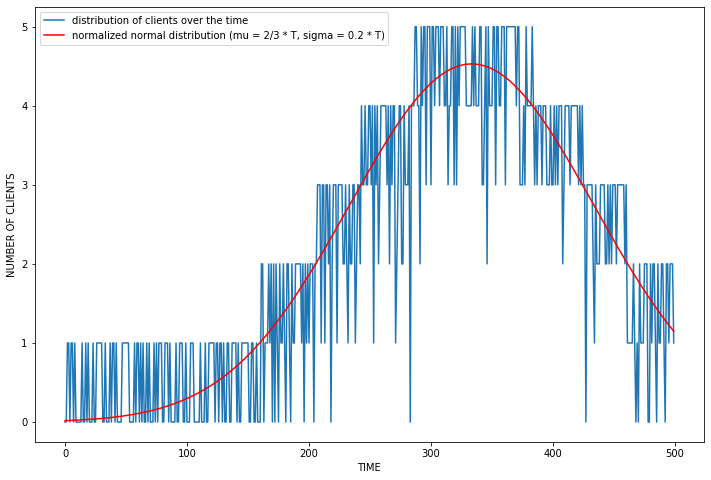

In [ ]:
time_distribution = get_time_distribution(T,NC)
plot_time_distribution(time_distribution)

### *I.D. THE DEMAND*

Thanks to the previous part we know how many clients are going to order food a certain time t. Now, so as to determine the demand of each of the restaurants, we have to find a distribution functions of the **current_NC** clients among the **NR** restaurants with respects to **RATINGS** and **PRICES** (an array containg the respective prices of the restaurants at some point).

To do so we consider for each restaurant the ratio between its rating and its normalized price (ratio between the price and P$_{MAX}$) multiplied by $1.25$ to give $33$% more importance to the rating. In fact, according to some studies, it seems that people are more interested in the rating than they are to the price when choosing a product with an online business. Here are some of the studies and articles read:
- [Quality More Important to Consumers than Price as Influence of Discounts on Purchase Decisions Declines](https://www.firstinsight.com/press-releases/quality-more-important-than-price-study#:~:text=June%2025%2C%202018%20%E2%80%93%20Quality%20is,retailers%20make%20product%20investment%20and)
- [Online reviews statistics to know in 2021](https://www.qualtrics.com/blog/online-review-stats/)
- [Survey Confirms the Value of Reviews, Provides New Insights](https://www.powerreviews.com/blog/survey-confirms-the-value-of-reviews/)

This ratio determines the order in which a client would consider the restaurants while ordering. When a client has picked a restaurant to determine whether he is going to order there or consider the following restaurant, we consider a probability law based only on the data of the current restaurant (rating and price).

If a restaurant doesn't have enough meals for the number of clients it has been assigned, the remaining clients will be dispatched in the other restaurants. If at some point all the restaurants are full they are about to empty their stock), the platform will close.

*Remark: In order to build an even more realistic model we could have considered a food classification of the restaurants among a finite set of categories (e.g. spicy food -> 0, sushi -> 1, pizza -> 3) and randomly given a preference policy to each of the clients. Moreover if a restaurant is full, they is a probability that the clients not served prefer not to order in any of the other restaurant, but we didn't implement such behaviour since we don't know that probability*

In [ ]:
# the demand function
def demand(t,RATINGS,PRICES,STOCKS):

  current_NC = int(time_distribution[t])

  # an array giving the ratios of the restaurants
  restaurants_ratios = np.zeros([NR])

  for i,rating in enumerate(RATINGS):

    # quality-price ratio
    r = (1.33 * rating) / (PRICES[i] / P_MAX)
    restaurants_ratios[i] = r

  
  client_repartition = np.zeros([NR])
  probas = restaurants_ratios / np.sum(restaurants_ratios)

  for i in range(current_NC):

    # the number of restaurant visited
    count = 1
    ind = int(np.random.choice(np.arange(NR), p=probas))
    restaurants_visited = [ind]

    if STOCKS[ind] == client_repartition[ind]:

        go = 0

    else:
      
      proba = RATINGS[ind] * np.sqrt((1 - np.sqrt(PRICES[ind]/P_MAX)))
      go = np.random.choice(np.arange(2),p=[1-proba,proba])
    
      if go:
        client_repartition[ind] += 1
    
    while count < NR and go == 0:

      count += 1
      ind = int(np.random.choice(np.arange(NR), p=probas))
      while ind in restaurants_visited:
        ind = int(np.random.choice(np.arange(NR), p=probas))
      restaurants_visited.append(ind)
      
      if STOCKS[ind] == client_repartition[ind]:
        go = 0

      else:

        proba = RATINGS[ind] * np.sqrt((1 - np.sqrt(PRICES[ind]/P_MAX)))
        go = np.random.choice(np.arange(2),p=[1-proba,proba])
      
        if go:
          client_repartition[ind] += 1
  
  return client_repartition

### *I.E. REWARD*

In [ ]:
# default penalty factor
PF = 100 

In [ ]:
# reward function
def get_reward(p,c_sold,c_kept,t,r):

  # no more time remaining but some stock left
  if t == 0:
    rw = - PF * P_MAX * c_kept

  else:
    rw = p * c_sold
  
  return rw

## **II. ENVIRONMENT**

Now that we have defined the initial parameters of our model, we have to determine the environment (the restaurants) on which our agent (the platform) is going to operate.

The restaurants are defined by two criteria: the **observation space** and the possible **actions** applied to it.

The observation space here

**Remarks:**

- ACTIONS<br>For each of the $N\_R$ restaurants, an action is the fact of setting a price $p$ among $N\_P+1$ possible values between $P\_MIN$ and $P\_MAX$ (both included) which is also choosing the index of an element in $A$.

- STATES<br>For each of the $N\_R$ restaurants, a state is the current stock of the restaurant with $C\_MAX-C\_MIN+1$ possible values between $C\_MIN$ and $C\_MAX$ (both included).

In [ ]:
# for policies other than the dynamic one
def get_prices(policy):

  if policy in POLICIES:
    
    if policy == "average":
      prices = [(P_MIN + P_MAX) / 2 for i in range(NR)]
      
    elif policy == "max":
      prices = [P_MAX for i in range(NR)]
    
    elif policy == "min":
      prices = [P_MIN for i in range(NR)]
    
    elif policy == "random":
      prices = [np.random.choice(A) for i in range(NR)]
    
    return prices
    
  else:

    error_message = "Invalid policy: {}\nChoose one of these:".format(policy)

    for allowed_policy in POLICIES:
      error_message += " " + allowed_policy
    
    raise ValueError(error_message)
  

In [ ]:
class CustomEnv(gym.Env):
  


  metadata = {'render.modes': ['human']}



  def __init__(self):
    
    super(CustomEnv, self).__init__()

    # ACTIONS = SETTING PRICE OF THE MEALS IN RESTAURANTS
    self.action_space = Tuple([Discrete(NP+1) for i in range(NR)])
    
    # SPACES = STOCK (0 to C_MAX) & PRICES (P_MIN to P_MAX) OF THE RESTAURANTS
    obs_space = []
    for i  in range(NR):
      obs_space.append(Tuple([Discrete(C_MAX + 1), Discrete(NP + 1)]))
    self.observation_space = Tuple(obs_space)

    # INITIAL TIME REMAINING
    self.time_remaining = T-1
    
    # INITIAL STATES OF THE RESTAURANTS
    # (rating, stock, price, current reward, cumulative reward since T_MIN)
    self.restaurants = [(rating, C_MAX, P_MAX, 0, 0) for rating in RATINGS]



  def step(self, action):

    # time remaining
    t = self.time_remaining

    # policy to follow
    policy = action[0]
    
    if policy == "dynamic":
      prices = [P_MIN + action[1][i] * (P_MAX - P_MIN) / NP for i in range(NR)]
    
    else:
      prices = get_prices(policy)
    
    stocks = [restaurant[1] for restaurant in self.restaurants]

    client_distribution = demand(t, RATINGS, prices, stocks)
    
    # to keep track of the maximum of the restaurants stocks
    max_stock = -1

    for i,restaurant in enumerate(self.restaurants):

      # rating
      r = restaurant[0]

      # current stock
      c = restaurant[1]

      # price
      p = prices[i]

      # demand
      d = int(client_distribution[i])

      # stock sold and new current stock
      c_sold = d
      c_kept = c - c_sold

      max_stock = max(max_stock, c_kept)

      # current reward
      rw = get_reward(p,c_sold,c_kept,t,r)
      
      # cumulative reward
      crw = restaurant[4] + rw
      
      # update the state of the restaurant
      self.restaurants[i] = (r,c_kept,p,rw,crw)
    
    # no more stock or time remaining equals to 0
    if max_stock == 0 or self.time_remaining == 0:
      done = True
    
    else:
      done = False
    
    # the time remaining decrease
    self.time_remaining -= 1

    return self.restaurants, done


  def reset(self):

    # INITIAL TIME REMAINING
    self.time_remaining = T-1
    
    # INITIAL STATES OF THE RESTAURANTS
    # (rating, stock, price, current reward, cumulative reward since T_MIN)
    self.restaurants = [(rating, C_MAX, P_MAX, 0, 0) for rating in RATINGS]
    
    return self.restaurants
  

  def render(self, mode='human', close=False):

    print("----------\n")

    for i,restaurant in enumerate(self.restaurants):
      r, c, p, rw, crw = restaurant 
      print("RESTAURANT {}".format(i+1))
      print("rating: {}\t| stock: {}\t| price: {}\t| reward: {}\t| cumulated reward: {}\n".format(r,c,p,rw,crw))

## **III. Q-LEARNING**

In [ ]:
def initialize_q_tables(NR, C_MAX, NP):

  # each restaurant has its own q_table
  q_tables = np.random.rand(NR, C_MAX + 1, NP + 1)
  for i in range(NR):
    q_tables[i][0] = np.zeros([NP+1])
  
  return q_tables

In [ ]:
def process(policy, q_table, max_epoch, period):

  env = CustomEnv()

  # hyperparameters
  alpha = 0.3
  gamma = 0.6
  epsilon = 0.1
  average_prices = np.zeros([T])

  for j in range(1,max_epoch+1):

    states = env.reset()

    epochs, penalties, reward = 0,0,0
    done = False

    steps = 0

    while not done:

      # explore action space (epsilon-greedy)
      if np.random.random() < epsilon:
        action = (policy, list(env.action_space.sample()))  
      
      # exploit learned values
      else:
        prices = [] 
        for i,restaurant in enumerate(states):
          c = restaurant[1]
          q_table = q_tables[i]
          prices.append(np.argmax(q_table[c]))
        action = (policy, prices)
      
      prices = action[1]

      next_states, done = env.step(action)

      current_prices = np.array([next_states[i][2] for i in range(NR)])
      current_price = np.sum(current_prices) / NR

      average_prices[steps] += current_price
      steps += 1

      # q_learning values for the states "states" under the actions "actions"
      old_values = []
      for i,restaurant in enumerate(states):
        c = restaurant[1]
        q_table = q_tables[i]
        price = prices[i]
        old_values.append(q_table[c][price])

      # max q_learning values for the states "states" under the actions "actions"
      next_maxs = []
      for i,restaurant in enumerate(next_states):
        c = restaurant[1]
        q_table = q_tables[i]
        next_maxs.append(np.max(q_table[c]))

      # update of the q_learning values
      for i,restaurant in enumerate(next_states):
        c = restaurant[1]
        rw = restaurant[3]
        q_tables[i][c][prices[i]] = (1-alpha)*old_values[i] + alpha*(rw+gamma*next_maxs[i]) 

    if j % period == 0:
      env.render()
  
  average_prices = average_prices / max_epoch

  return q_tables, average_prices

In [ ]:
PF = 100
q_tables = initialize_q_tables(NR, C_MAX, NP)
q_tables, prices = process("dynamic", q_tables, 100000, 1000)

----------

RESTAURANT 1
rating: 0.76	| stock: 0	| price: 1.0	| reward: 0	| cumulated reward: 1261.0

RESTAURANT 2
rating: 0.77	| stock: 21	| price: 2.0	| reward: -21000	| cumulated reward: -19848.0

RESTAURANT 3
rating: 0.8	| stock: 0	| price: 4.0	| reward: 0	| cumulated reward: 1257.0

----------

RESTAURANT 1
rating: 0.76	| stock: 57	| price: 7.0	| reward: -57000	| cumulated reward: -55849.0

RESTAURANT 2
rating: 0.77	| stock: 0	| price: 8.0	| reward: 0	| cumulated reward: 1289.0

RESTAURANT 3
rating: 0.8	| stock: 0	| price: 1.0	| reward: 0	| cumulated reward: 1308.0

----------

RESTAURANT 1
rating: 0.76	| stock: 0	| price: 5.0	| reward: 0	| cumulated reward: 1326.0

RESTAURANT 2
rating: 0.77	| stock: 14	| price: 10.0	| reward: -14000	| cumulated reward: -12737.0

RESTAURANT 3
rating: 0.8	| stock: 29	| price: 8.0	| reward: -29000	| cumulated reward: -27758.0

----------

RESTAURANT 1
rating: 0.76	| stock: 30	| price: 4.0	| reward: -30000	| cumulated reward: -28758.0

RESTAURANT 2
r

Text(0, 0.5, 'AVERAGE PRICE')

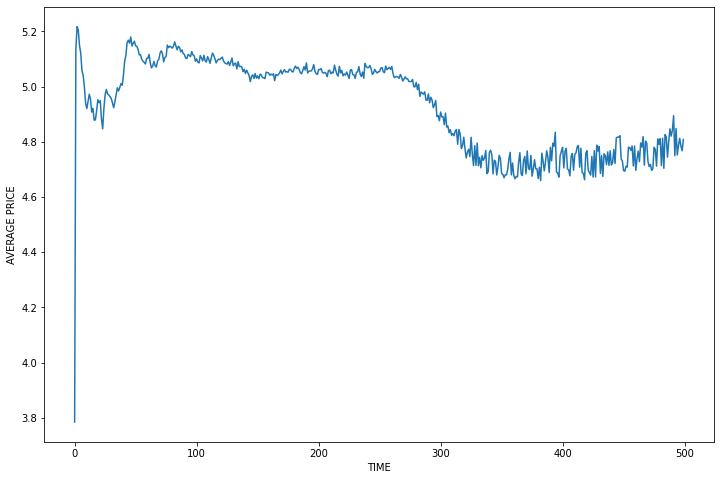

In [ ]:
x = np.arange(T)
y = prices
plt.plot(x,y)
plt.xlabel("TIME")
plt.ylabel("AVERAGE PRICE")

## **IV. EXPERIENCES**

### *IV.1 REWARD INFLUENCE*

### *IV.2 POLICY INFLUENCE*
